<a href="https://colab.research.google.com/github/FabysMV/Detection_depress/blob/main/depression_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este primer bloque se importa la librería necesaria para conectar el contenido de Google Drive.

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Solo se ejecuta este bloque para verificar que se haya realizado la conexión correctamente
!ls "/content/drive/My Drive"  # Para ver si se accedió a los documentos correctamente

En este bloque de código, se importan las librerías necesarias para realizar los cálculos del análisis de las transcripciones.

In [ ]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import os
nltk.download('punkt')
from google.colab import files

# Funciones

---


En este bloque se cargan todas las funciones que son utilizadas para llevar a cabo el análisis lexicométrico que se ha solicitado.





*  ***delta_time: cálculo de la diferencia de tiempo***

Función para calcular la diferencia de tiempo de cada intervención, así se calcula el tiempo real en el que la persona estuvo hablando.
```
def delta_time(time1, time2):
    """Devuelve la duracion total
        delta_time(df["tiempo inicial], df["tiempo final"])
        df == data frame"""
    # Sumamos tiempo uno
    tot_t1 = time1.sum()
    tot_t2 = time2.sum()

    return tot_t2 - tot_t1
```

* **tam_word: tamaño promedio de caracteres**

En esta función se calcula el promedio de caracteres que utilizó la persona.
Se suma el total de caracteres y se divide entre la cantidad de palabras de la transcripción.


```
def tam_word(palabras):
    """ Devuelve el promedio de caracteres usados en la trasncripción"""
    # palabras = nltk.word_tokenize(trans)  # devuelve lista de palabras
    if not palabras:
        return 0
    len_palabras = [len(palabra) for palabra in palabras]
    return sum(len_palabras) / len(palabras)  # promedio de tamaño de palabras
```

* **tam_sentence :  promedio y std del tamaño de cada intervención**

Devuelve el promedio y la desviación estandar del tamaño de cada intervención, las cuales son tratadas como oraciones.

Palabras = número total de palabras de la transcripción
oracion = lista de oraciones de la transcripción
len_oracion = lista cuyos elementos son la longitud de cada oración

Se regresa una lista en donde el primer elemento es el promedio de palabras por oración y el segundo su desviación estándar.
```
def tam_sentence(palabras, oracion):
    """Devuelve el promedio y la desviación estándar de palabras por oración
    type = list donde el primer elemento es el promedio y el segundo la desviación estándar"""
    if not palabras:
        return [0, 0]
    len_oracion = [len(RegexpTokenizer(r'\w+').tokenize(orac)) for orac in oracion]
    return [len(palabras)/len(oracion), np.sqrt(np.var(len_oracion))]
```

* **rel_oracion_palabra: relación entre cantidad de oraciones y palabras**

Devuelve una lista en donde el primer elemento corresponde a la relación del número de las oraciones entre las palabras usadas. Esto mide la complejidad de cada intervención, si el número es grande entonces la complejidad es baja, pero si el número es pequeño implicará que se tienen oraciones complejas.

El segundo elemento es la relación entre el número de oraciones y el tamaño del vocabulario. Esto mide la riqueza del vocabulario, si el valor es bajo entonces se tiene un vocabulario rico, pero si es alto significa que se utiliza un vocabulario limitado.


```
def rel_oracion_palabra(palabras, oraciones):
    """Devuelve la relacion entre cantidad de oraciones y palabras
    type = list
    Primer elemento = Tamaño de las oraciones(en promedio (?)) / Tamaño del vocabulario
    Segundo elemento = Número de oraciones / Tamaño del vocabulario"""
    if not palabras:
        return [0, 0]
    num_or = len(oraciones)
    tam_vocab = len(set(palabras))
    # Número de oraciones / Tamaño del vocabulario
    return [num_or/len(palabras), num_or/tam_vocab]

```

* **vocab_rich: riqueza del vocabulario y hapax/vocabulario**

Esta función devuelve una lista. \



*  Primer elemento: la relación entre las palabras en total y el vocabulario, de esta forma se ve cuántas veces se repiten las palabras en promedio. Si es cercano a 1 entonces significa que se tiene vocabulario rico.

*   Segundo elemento: devuelve la relación de Hapax entre el tamaño de vocabulario. Un valor cercano a 1 indica que se tiene alta diversidad léxica.



```
def vocab_rich(palabras):
    """Devuelve una lista
          rtype: list
          >> [numero de palabras, tamaño de vocabulario, lista de Hapaxes]"""
    tam_vocab = len(set(palabras))  # tamaño de vocabulario
    #	Número de palabras / tamaño del vocabulario
    # o	Número de Hapax / Tamaño del vocabulario
    # Para encontrar los Hapaxes primero hay que aplicar la distribución de frecuencia
    fdist = nltk.FreqDist(palabras)
    hapaxes = fdist.hapaxes()
    return [len(palabras), tam_vocab, hapaxes]
```

* **cal_prom(df, type): Calcular el promedio y separar pacientes**

En esta función se calcula la duración promedio y el tamaño de palabras promedio toda la transcripción, separando por depresivos y no depresivos y a su vez se separan por partición: test,  entrenamiento, desarrollo (dev).

* **CountHapax(localH, generalH)**

Esta función calcula la intersección de los hapax de toda la transcripción con la que se contaron en los pacientes de forma individual. De esta forma se obtiene el número de palabras del paciente que pertenecen al conjunto de los Hapax.
```
def CountHapax(localH, generalH):
  return len(set(localH) & set(generalH))
  ```

* **Clean(trans)**
Esta función limpia la transcripción de caracteres no deseados como los signos de puntuación y otro tipo de caracteres que entorpecen el análisis del texto.
Usa la función de expresiones regulares de NLTK

```
def Clean(trans):
  c_trans = RegexpTokenizer(r'\w+')
  palabras = c_trans.tokenize(trans)
  oraciones = nltk.tokenize.sent_tokenize(trans)
  return (oraciones, palabras)
  ```

In [78]:
# Funciones de calculos
# Los tiempos y la transcripción ya debe de estar filtrada
def delta_time(time1, time2):
    """Devuelve la duracion total
        delta_time(df["tiempo inicial], df["tiempo final"])
        df == data frame"""
    # Sumamos tiempo uno
    tot_t1 = time1.sum()
    tot_t2 = time2.sum()

    return tot_t2 - tot_t1


def tam_word(palabras):
    """ Devuelve el promedio de caracteres usados en la trasncripción"""
    # palabras = nltk.word_tokenize(trans)  # devuelve lista de palabras
    if not palabras:
        return 0
    len_palabras = [len(palabra) for palabra in palabras]
    return sum(len_palabras) / len(palabras)  # promedio de tamaño de palabras


def tam_sentence(palabras, oracion):
    """Devuelve el promedio y la desviación estándar de palabras por oración
    type = list donde el primer elemento es el promedio y el segundo la desviación estándar"""
    if not palabras:
        return [0, 0]
    len_oracion = [len(RegexpTokenizer(r'\w+').tokenize(orac)) for orac in oracion]
    return [len(palabras)/len(oracion), np.sqrt(np.var(len_oracion))]


def rel_oracion_palabra(palabras, oraciones):
    """Devuelve la relacion entre cantidad de oraciones y palabras
    type = list
    Primer elemento = Tamaño de las oraciones(en promedio (?)) / Tamaño del vocabulario
    Segundo elemento = Número de oraciones / Tamaño del vocabulario"""
    if not palabras:
        return [0, 0]
    num_or = len(oraciones)
    tam_vocab = len(set(palabras))
    # Número de oraciones / Tamaño del vocabulario
    return [num_or/len(palabras), num_or/tam_vocab]


def vocab_rich(palabras):
    """Devuelve una lista
          rtype: list
          >> [numero de palabras, tamaño de vocabulario, lista de Hapaxes]"""
    tam_vocab = len(set(palabras))  # tamaño de vocabulario
    #	Número de palabras / tamaño del vocabulario
    # o	Número de Hapax / Tamaño del vocabulario
    # Para encontrar los Hapaxes primero hay que aplicar la distribución de frecuencia
    fdist = nltk.FreqDist(palabras)
    hapaxes = fdist.hapaxes()
    return [len(palabras), tam_vocab, hapaxes]

def cal_prom(df, type):
    gen = []
    dep = df[(df["PHQ_Binary"] == 1)]
    no_dep = df[(df["PHQ_Binary"] == 0)]
    # separar a los depresivos de los no depresivos y sacar la suma de palabras y tiempo (promedio y desviacion )

    if dep.empty:
      print("ouch")
      wtr_depresivo = "N/A"
      time_depresivo = "N/A"
      d_depresivo_word = "N/A"
      d_depresivo_time = "N/A"
    else:
      wtr_depresivo = dep["Palabras"].sum() / dep["Palabras"].count()
      time_depresivo = dep["Duracion"].sum() / dep["Duracion"].count()
      d_depresivo_word = dep["Palabras"].std()
      d_depresivo_time = dep["Duracion"].std()

    g = {"Particion": type, "Numero de pacientes": dep["Participant_ID"].count() ,"Diagnostico": "Depresivo", "Promedio de palabras": d_depresivo_word,
                      "Promedio de duración": d_depresivo_time}
    gen.append(g)
    if no_dep.empty:
      print("no sad ouch")
      wtr_no_depresivo = "N/A"
      time_no_depresivo = "N/A"
      d_no_depresivo_word = "N/A"
      d_no_depresivo_time = "N/A"
    else:
      wtr_no_depresivo = no_dep["Palabras"].sum() / no_dep["Palabras"].count()
      time_no_depresivo = no_dep["Duracion"].sum() / no_dep["Duracion"].count()
      # desviacion estándar
      d_no_depresivo_word = no_dep["Palabras"].std()
      d_no_depresivo_time = no_dep["Duracion"].std()

    g = {"Particion": type,"Numero de pacientes": no_dep["Participant_ID"].count() , "Diagnostico": "No depresivo", "Promedio de palabras": d_no_depresivo_word,
                      "Promedio de duración": d_no_depresivo_time}
    gen.append(g)
    # nuevo data frame
    return gen


def CountHapax(localH, generalH):
  return len(set(localH) & set(generalH))


def Clean(trans):
  c_trans = RegexpTokenizer(r'\w+')
  palabras = c_trans.tokenize(trans)
  oraciones = nltk.tokenize.sent_tokenize(trans)

  return (oraciones, palabras)


# Análisis para DAIC-WOZ


---

En este bloque se realiza el análisis y la creación de un nuevo data frame en donde se registrarán los resultados de las medidas lexicométricas.

Para realizar lo anteriormente mencionado, se siguen los siguientes pasos:


1.   Cargar el dataset accediendo a su carpeta correspondiente en Google Drive.
2.   Se recorre cada uno de los folders que hay en DAIC-WOZ y se escoge el archivo .csv que contiene la transcripción.
3.  Se hace el filtrado en donde se eliminan las filas que corresponden a la introducción de la entrevista y también se elimina la participación de "Ellie".
4.  Para cada paciente, se guardan los resultados en un diccionario y a su vez se almacena en una lista que contendrá a todos los diccionarios de los pacientes, esto servirá para crear el nuevo dataframe.



In [79]:
# Importar los datos .csv desde Drive
#Para DAIC-WOZ hay que hacer el filtro de Ellie

#Dirección de carpeta para DAIC-WOZ
folder_DAIC = '/content/drive/My Drive/DAIC-WOZ'
filas = []
train = pd.read_csv(os.path.join(folder_DAIC, "train_split_Depression_AVEC2017.csv"), sep = ",")
test = pd.read_csv(os.path.join(folder_DAIC, "full_test_split1-csv.csv"), sep = ",")
train = train[["Participant_ID", "PHQ8_Binary"]]
test = test[["Participant_ID", "PHQ_Binary"]]
complete_trans = []
# Usando OS se hace el recorrido por todos los folders
for folder_ids in os.listdir(folder_DAIC):
    folder_id = os.path.join(folder_DAIC, folder_ids)

    # Check if it's a directory and matches the pattern "id_p"
    if os.path.isdir(folder_id) and folder_id.endswith('_P'):
        # print(f"Accessing folder: {folder_id}")

        # Accediendo al transcript dentro del folder del paciente
        for file in os.listdir(folder_id):
            if file.endswith('TRANSCRIPT.csv') and file[0].isdigit():
                file_path = os.path.join(folder_id, file)
                # print(f"Accessing file: {file_path}")
                data = pd.read_csv(file_path, sep='\t')
                # aqui va el filtrado para despues de la introduccion
                cont = data['value'].str.contains('ye', case=False, na=False) | data['value'].str.contains('ok', case=False, na=False)
                data_index = data[cont].index
                # solo tomar en cuenta lo que va después de la intro
                data_filter = data.iloc[data_index[0]+1:]
                data_filter = data_filter[(data_filter['speaker'] != "Ellie")]
                # Convertimos en oración cada celda
                trans = '. '.join(str(val) for val in data_filter["value"])
                # Hay que limpiar los signos de puntuación despues de haber separado por oraciones
                # Guardamos la transcripción después de la limpieza
                # Limpiar transcripción
                (oraciones, palabras) = Clean(trans)
                complete_trans.append(palabras)
                # print(trans)
                # llamar a funciones
                # palabras = nltk.word_tokenize(trans)
                # oraciones = nltk.tokenize.sent_tokenize(trans)
                t_s = tam_sentence(palabras, oraciones)
                r_o_p = rel_oracion_palabra(palabras, oraciones)
                v_r = vocab_rich(palabras)

                fila = {"Participant_ID": int(file[0:3]), "Promedio de caracteres": tam_word(palabras), "Palabras por oracion":t_s[0] ,
                        "Desviacion estándar": t_s[1], "Tamaño de oracion/vocabulario": r_o_p[0],
                        "Oraciones/vocabulario": r_o_p[1],
                        "Numero de palabras": v_r[0], "Tamaño de vocabulario": v_r[1], "Hapax local": v_r[2], "Numero de Hapax local": len(v_r[2]),
                         "Palabras": len(palabras), "Oraciones": len(oraciones),
                        "Duracion": delta_time(data_filter["start_time"], data_filter["stop_time"])}

                # llenar lista con valores del nuevo df
                filas.append(fila)



In [81]:
df = pd.DataFrame(filas)
df = df.sort_values(by = "Participant_ID")

# Calculamos los HAPAX totales
h = [word for sublist in df['Hapax local'] for word in sublist]
fdis = nltk.FreqDist(h)
hapaxes = fdis.hapaxes()  # Lista de hapaxes

# Contamos los hapax de cada paciente con respecto a los Hapaxes totales
# Una nueva columna es agregada, sobre ésta se realizan los cálculos de riqueza de vocabulario
df['Hapax'] = df['Hapax local'].apply(lambda x: len(set(x) & set(hapaxes)))
df['Numero de palabras/ tamaño de vocabulario'] = df['Numero de palabras']/df['Tamaño de vocabulario']
df['Hapax / tamaño de vocabulario'] = df['Hapax']/ df['Tamaño de vocabulario']
#df = df.drop("Hapax local", axis = 1, inplace = True)


En este bloque de código se crea el nuevo dataframe usando la lista que se creó con el código anterior. El nuevo dataframe se ordena por ID de paciente.

Después se crea un nuevo data frame en donde se almacenan los pacientes que corresponden a **"train"** y otro para **"test"** haciendo la relación con el documento en el que se etiquetan a los pacientes en "train" y "test", esto se logra usando merge.

Además, se realiza la descarga de dos archivos .csv, el primero es "DAIC_WOZ.csv" que contiene las medidas lexicometricas de cada uno de los pacientes.
El segundo es "DAIC_WOZ_time_words.csv" y contiene el promedio de palabras y duración de todos los pacientes divididos por categorías.



In [83]:
# hacemos nuevo df separando a los que fueron de train y los de test
p_train = pd.merge(df,train, on = "Participant_ID") # solo los que son de train
p_train.rename(columns = {'PHQ8_Binary':"PHQ_Binary"}, inplace = True)
p_test = pd.merge(df,test, on = "Participant_ID")   # solo los de test
p_test.rename(columns = {'PHQ_Binary':"PHQ_Binary"}, inplace = True)


df.to_csv("DAIC_WOZ.csv", index = False,  sep = ",")
files.download("DAIC_WOZ.csv")

train_r = cal_prom(p_train, "Train")
test_r = cal_prom(p_test, "Test")
df_time_words = pd.DataFrame(train_r + test_r)
df_time_words.to_csv("DAIC_WOZ_time_words.csv", index = False,  sep = ",")
files.download("DAIC_WOZ_time_words.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! pip install seaborn

# Violin plot de DAIC-WOZ


---


Para visualizar cada una de las medidas lexicométricas calculadas en los bloques anteriores, se realiza un violin plot.

La gráfica está dividia en dos grupos: depresivos y no depresivos. Los depresivos se representan con 1 y los no depresivos con 0.

Cada color en la gráfica representa la partición correspondiente de los pacientes. En este caso solo que tiene *"test"* y *"train"*.





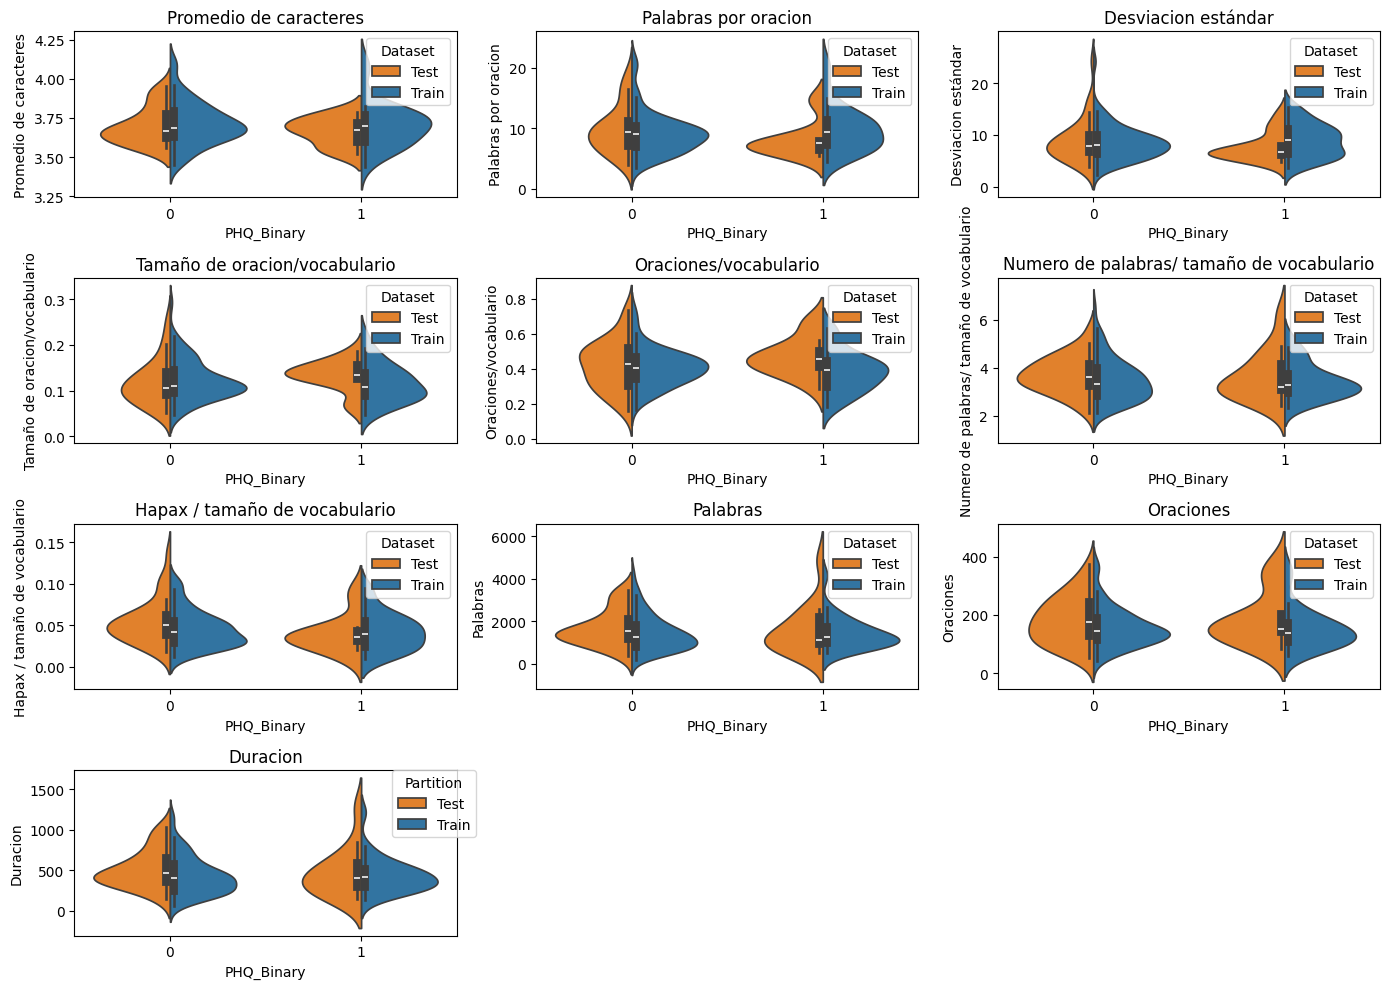

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes los DataFrames llamados 'test' y 'train'
# Añadir una nueva columna para identificar el origen de los datos
p_test['Dataset'] = 'Test'
p_train['Dataset'] = 'Train'

# Combinar los DataFrames
df_combined = pd.concat([p_test, p_train])

# Lista de las columnas que quieres graficar
columnas = ['Promedio de caracteres', 'Palabras por oracion',
       'Desviacion estándar', 'Tamaño de oracion/vocabulario',
       'Oraciones/vocabulario', 'Numero de palabras/ tamaño de vocabulario',
       'Hapax / tamaño de vocabulario', 'Palabras', 'Oraciones', 'Duracion']

# Crear gráficos violinplot con separación por 'Dataset' y 'PHQ_Binary'
plt.figure(figsize=(14, 10))  # Tamaño de la figura

for i, col in enumerate(columnas, 1):
    plt.subplot(4, 3, i)  # Crear una subtrama para cada gráfica
    sns.violinplot(x='PHQ_Binary', y=col, hue='Dataset', data=df_combined, split=True, palette={'Train': '#1f77b4', 'Test': '#ff7f0e'})
    plt.title(col)

handles, labels = plt.gca().get_legend_handles_labels()  # Obtener handles y labels
plt.legend(handles=handles[:3], labels=labels[:3], loc='upper right', title='Partition', bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Posiciona la leyenda afuera

plt.tight_layout()  # Para ajustar los gráficos y que no se sobrepongan
plt.show()


# Análisis para E-DAIC


---

En este bloque se realiza el análisis y la creación de un nuevo data frame en donde se registrarán los resultados de las medidas lexicométricas.

Para realizar lo anteriormente mencionado, se siguen los siguientes pasos:


1.   Cargar el dataset accediendo a su carpeta correspondiente en Google Drive.
2.   Se recorre cada uno de los folders que hay en DAIC-WOZ y se escoge el archivo .csv que contiene la transcripción.
3.  Para cada paciente, se guardan los resultados en un diccionario y a su vez se almacena en una lista que contendrá a todos los diccionarios de los pacientes, esto servirá para crear el nuevo dataframe.


In [88]:
#Dirección de carpeta para DAIC-WOZ
folder_e_DAIC = '/content/drive/My Drive/E-DAIC'
filas_e = []
#1.- -	Tamaño promedio (y desviación estándar) de
# las transcripciones, en palabras y en tiempo; por intervenciones o entrevista completa

#text = pandas.read_csv()
complete_trans = []

for folder_ids in os.listdir(folder_e_DAIC):
    folder_id = os.path.join(folder_e_DAIC, folder_ids)

    # Check if it's a directory and matches the pattern "id_p"
    if os.path.isdir(folder_id) and folder_id.endswith('_P'):
        # print(f"Accessing folder: {folder_id}")

        # Accediendo al transcript dentro del folder del paciente
        for file in os.listdir(folder_id):
            if file.endswith('ranscript.csv'):
                file_path = os.path.join(folder_id, file)
                # print(f"Accessing file: {file_path}")
                data = pd.read_csv(file_path, sep=',')
                # print(data)
                trans = '. '.join(data["Text"])
                (oraciones, palabras) = Clean(trans)
                complete_trans.append(palabras)
                # llamar a funciones
                t_s = tam_sentence(palabras, oraciones)
                r_o_p = rel_oracion_palabra(palabras, oraciones)
                v_r = vocab_rich(palabras)

                fila_e = {"Participant_ID": int(file[0:3]), "Promedio de caracteres": tam_word(palabras), "Palabras por oracion":t_s[0] ,
                        "Desviacion estándar": t_s[1], "Tamaño de oracion/vocabulario": r_o_p[0],
                        "Oraciones/vocabulario": r_o_p[1],
                         "Numero de palabras": v_r[0], "Tamaño de vocabulario": v_r[1], "Hapax local": v_r[2], "Numero de Hapax local": len(v_r[2]),
                         "Palabras": len(palabras), "Oraciones": len(oraciones),
                        "Duracion": delta_time(data['Start_Time'], data['End_Time'])}
                # print(filas)
                # llenar lista con valores del nuevo df
                filas_e.append(fila_e)



En este bloque, se crea el nuevo dataframe y se guarda en un archivo .csv y se descarga.

In [89]:
df_e = pd.DataFrame(filas_e)
df_e = df_e.sort_values(by = "Participant_ID")

# Calculamos los HAPAX totales
h = [word for sublist in df_e['Hapax local'] for word in sublist]
fdis = nltk.FreqDist(h)
hapaxes = fdis.hapaxes()  # Lista de hapaxes

# Contamos los hapax de cada paciente con respecto a los Hapaxes totales
# Una nueva columna es agregada, sobre ésta se realizan los cálculos de riqueza de vocabulario
df_e['Hapax'] = df_e['Hapax local'].apply(lambda x: len(set(x) & set(hapaxes)))
df_e['Numero de palabras/ tamaño de vocabulario'] = df_e['Numero de palabras']/df_e['Tamaño de vocabulario']
df_e['Hapax / tamaño de vocabulario'] = df_e['Hapax']/ df_e['Tamaño de vocabulario']
# df_e = df_e.drop("Hapax local", axis = 1, inplace = True)

df_e.to_csv("E-DAIC.csv", index = False, sep = ",")
files.download("E-DAIC.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Al igual que en el análisis anterior, se crean tres nuevos dataframes tomando en cuenta la partición.

Para cada dataframe se calcula el promedio de palabras y duración de cada paciente, y se concatenan los resultados para crear otro dataframe en donde se guarda dicha información.

In [90]:
datas_e = pd.read_csv(os.path.join(folder_e_DAIC, "AllDataSet.csv"), sep = ",")
datas_e = datas_e[["Participant_ID", "PHQ_Binary", "Partition"]]
# Juntamos los data frame con el documento de all data set
p_e = pd.merge(df_e, datas_e, on = "Participant_ID") # solo los que son de train
# separamos por particiones y despues juntamos
dev_e = p_e[(p_e['Partition'] == "dev")]
train_e = p_e[(p_e['Partition'] == "train")]
test_e = p_e[(p_e['Partition'] == "test")]


df_time_words_e = pd.DataFrame(cal_prom(dev_e, "Dev") + cal_prom(train_e, "Train") + cal_prom(test_e, "Test"))
df_time_words_e.to_csv("E_DAIC_time_words.csv", index = False,  sep = ",")
files.download("E_DAIC_time_words.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Violin plot para E-DAIC
---

Al igual que para DAIC-WOZ, la gráfica se divide en depresivos y no depresivos con base en su PHQ.

En esta ocasión se tienen tres particiones: dev (desarrollo), train y test.

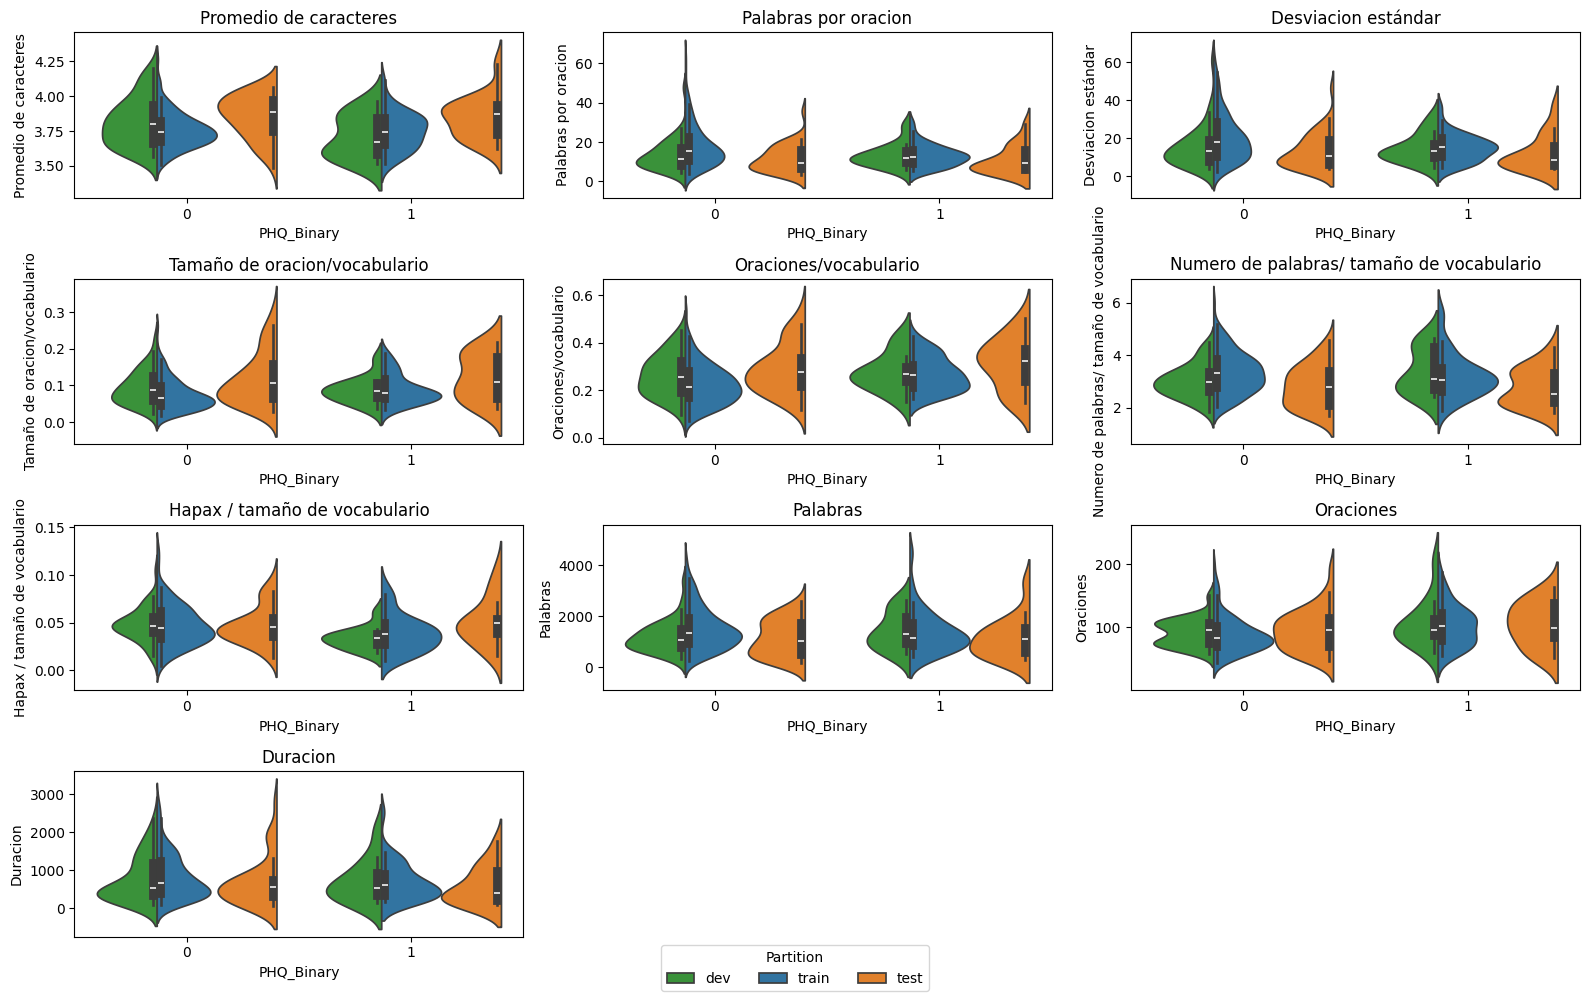

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# lista de columnas que se van a graficar
columnas = ['Promedio de caracteres', 'Palabras por oracion',
       'Desviacion estándar', 'Tamaño de oracion/vocabulario',
       'Oraciones/vocabulario', 'Numero de palabras/ tamaño de vocabulario',
       'Hapax / tamaño de vocabulario', 'Palabras', 'Oraciones', 'Duracion']

# Crear gráficos violinplot con separación por 'Partition' y 'PHQ_Binary'
plt.figure(figsize=(16, 10))  # Tamaño de la figura

# Iterar sobre las columnas
for i, col in enumerate(columnas, 1):
    plt.subplot(4, 3, i)  # Crear una subtrama para cada gráfica
    plot = sns.violinplot(x='PHQ_Binary', y=col, hue='Partition', data=p_e, split=True,
                          palette={'train': '#1f77b4', 'test': '#ff7f0e', 'dev': '#2ca02c'}, dodge=True)
    plot.legend_.remove()  # Remover la leyenda de cada subplot
    plt.title(col)

# Crear la leyenda de manera manual al final
handles, labels = plot.get_legend_handles_labels()  # Obtener handles y labels de la última gráfica
plt.figlegend(handles, labels, loc='lower center', title='Partition', ncol=3)

plt.tight_layout()  # Ajustar los gráficos
plt.show()


# Análisis con Frases de depresión

Importar el documento DepressionFrases.csv.
Se realiza la separación de las frases tanto por comas como por inicio de "I". Algunas vienen juntas y un indicador de separación es esa palabra.

In [92]:
# Se lee el documento
dep_path = '/content/drive/My Drive/Depression/DepressionFrases.csv'
dep_df = pd.read_csv(dep_path, sep = ',')

# Las columnas que nos interesan son "Interest_Phrases", "Depression_Phrases", "Tired_Phrases", "Appetite_Phrases",
# "Failure_Phrases", "Concentration_Phrases", "Moving_phrases"


In [94]:
# Se crea una nueva columna llamadda "Transcript" en donde se guardan las frases juntas
dep_df['Transcript'] = dep_df['Interest_Phrases'] + dep_df['Depression_Phrases'] + dep_df['Sleep_Phrases'] + dep_df['Tired_Phrases'] + dep_df['Appetite_Phrases']+ dep_df['Failure_Phrases'] + dep_df['Concentration_Phrases'] + dep_df['Moving_Phrases']


En este bloque de código se realizan los cálculos para los pacientes. Estos nuevos datos se almacenarán en un nuevo data frame.

In [95]:
complete_trans = []
filas = []
# Ciclo donde se acceden a los datos del paciente
for id in dep_df['0']:
  trans = dep_df[dep_df['0'] == id]['Transcript'].values[0]
  (oraciones, palabras) = Clean(trans)
  complete_trans.append(palabras)
  oraciones = [oracion.strip() for oracion in trans.split(',')]
  # llamar a funciones
  t_s = tam_sentence(palabras, oraciones)
  r_o_p = rel_oracion_palabra(palabras, oraciones)
  v_r = vocab_rich(palabras)

  fila = {"Participant_ID": int(id[0:3]), "Promedio de caracteres": tam_word(palabras), "Palabras por oracion":t_s[0] ,
          "Desviacion estándar": t_s[1], "Tamaño de oracion/vocabulario": r_o_p[0],
          "Oraciones/vocabulario": r_o_p[1],
          "Numero de palabras": v_r[0], "Tamaño de vocabulario": v_r[1], "Hapax local": v_r[2], "Numero de Hapax local": len(v_r[2]),
          "Palabras": len(palabras), "Oraciones": len(oraciones),
          "Duracion": delta_time(data_filter["start_time"], data_filter["stop_time"])}

  filas.append(fila)

En el siguiente bloque, se procede a crear el nuevo Data Frame y a calcular los Hapax de las transcripciones.

In [96]:
df_d = pd.DataFrame(filas)
df_d = df_d.sort_values(by = "Participant_ID")

# Calculamos los HAPAX totales
h = [word for sublist in df_d['Hapax local'] for word in sublist]
fdis = nltk.FreqDist(h)
hapaxes = fdis.hapaxes()  # Lista de hapaxes

# Contamos los hapax de cada paciente con respecto a los Hapaxes totales
# Una nueva columna es agregada, sobre ésta se realizan los cálculos de riqueza de vocabulario
df_d['Hapax'] = df_d['Hapax local'].apply(lambda x: len(set(x) & set(hapaxes)))
df_d['Numero de palabras/ tamaño de vocabulario'] = df_d['Numero de palabras']/df_d['Tamaño de vocabulario']
df_d['Hapax / tamaño de vocabulario'] = df_d['Hapax']/ df_d['Tamaño de vocabulario']
# df_e = df_e.drop("Hapax local", axis = 1, inplace = True)

df_d.to_csv("Depression Phrases.csv", index = False, sep = ",")
files.download("Depression Phrases.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
drive.flush_and_unmount()